In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import sys
sys.path.append("..")

from EDA_ML_Package.EDA_functions import Data_Analysis
from EDA_ML_Package.ML_functions import ML_models
from EDA_ML_Package.NN_functions import ANN_tabular_class


In [12]:
df = pd.read_csv("diabetic_data.csv")
df = df.replace('?', np.nan)  # Replacing ? with Nan

In [13]:
def descriptive_analysis(data, target_attribute='none'):
    """ A table is created with the characteristics of a dataframe
    The table is printed in the pdf report

    Parameters
    ----------
    df: (dataframe)
    target_attribute: (str) optional

    Output: table
    """
    
    # 1. Print describe()
    print(data.describe())
    
    df = round(data.copy(deep=True), 2)

    # 2. Print df size
    print('\nnumber of attributes: ', len(df.columns), '/ number of instances: ', len(df), '\n')

    # tc: table characteristics
    tc = pd.DataFrame(df.isnull().sum(), columns=['NaN'])
    tc['Unique'] = [len(df[i].unique()) for i in list(df.columns)]
    tc['type'] = df.dtypes

    indexValue = 3
    tc['values'] = [df[clm].unique().tolist()[:indexValue] for clm in list(df.columns)]

    # for i, vl_list in enumerate(df.values):
    #    sm['values'].iloc[i] = [round(vl, 3) for vl in vl_list]

    for x, vl in enumerate(tc['values']):
        if tc['Unique'].iloc[x] > 3:
            vl.append('...')
        for i, y in enumerate(vl):
            if len(str(y)) > 10:
                try:
                    vl[i] = y[:10] + '..'
                except Exception:
                    pass
    tc = tc.reset_index()
    tc = tc.astype(str)

    # 3. print table characteristics
    print(tc)

    if target_attribute != 'none':
        attribute_range(df, target_attribute)

def attribute_range(data, target_attribute):
    """ A table is created with the range of values of an attribute
    The table is printed in the pdf report

    Parameters
    ----------
    df: (dataframe)
    target_attribute: (str)

    Output: -
    """
    df = data.copy(deep=True)
    dx = groupby_count_percentage(df, [target_attribute])
    print('\nValue Distribution of the Target attribute\n')
    print(dx)
    return dx

In [14]:
descriptive_analysis(df, 'readmitted')

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

In [15]:
def groupby_count_percentage(df, listOfColumns):
    """ Creates a dataset that shows the distribution of attributes in count
    and percentage form.

    data: (dataframe)
    listOfColumns: (list) 1 to multiple attributes

    Output: data in dataframe form
    """

    data = df.copy(deep=True)
    data['count'] = 0
    data['percentage'] = 0

    if len(listOfColumns) == 1:
        df_gb = data.groupby(listOfColumns)[['count', 'percentage']].count().reset_index()
    else:
        df_gb = data.groupby(listOfColumns)[['count', 'percentage']].count().unstack().stack(dropna=False)
        df_gb = df_gb.reset_index()
    
    # Calculate percentage
    df_gb['percentage'] = (df_gb['percentage'] / df_gb['count'].sum() * 100).round(2)

    df_gb[listOfColumns[0]] = df_gb[listOfColumns[0]].astype(str)

    df_gb['Pop Per'] = 0
    ii = 0
    groupList = df_gb[listOfColumns[0]].to_list()
    groupList = [str(i) for i in groupList]

    for y in groupList:

        # df_gb.loc[ii, 'Pop Per'] = df_gb.groupby(listOfColumns[0]).sum().loc[y][0]
        df_gb.loc[ii, 'Pop Per'] = df_gb.groupby(listOfColumns[0]).sum()['count'].loc[y]
        ii = ii + 1

    df_gb['Pop Per'] = (df_gb['count']/df_gb['Pop Per']*100).round(2)

    data = data.drop(['percentage', 'count'], axis=1)
    return df_gb


In [16]:
groupby_count_percentage(df, ['change', 'A1Cresult'])

,change,A1Cresult,count,percentage,Pop Per
0,Ch,>7,1935,1.90,4.12
1,Ch,>8,5349,5.26,11.38
2,Ch,None,37521,36.87,79.81
3,Ch,Norm,2206,2.17,4.69
4,No,>7,1877,1.84,3.43
5,No,>8,2867,2.82,5.24
6,No,None,47227,46.41,86.25
7,No,Norm,2784,2.74,5.08


In [17]:
def bar_plot_count_percentage(data, att, attTarget, title, plotType='Both'):
    """ Creates a bar plot that compares 2 attributes, eg a random att vs
    the target attribute

    Parameters
    ----------
    df: (dataframe)
    att: (str)
    attTarget: (str)
    path: (str) path where the plot will be saved

    Output: buf (to be printed in the pdf)
    """

    df = data.copy(deep=True)
    gb = groupby_count_percentage(df, [att, attTarget])

    x = gb[att].str.split(",", n=1, expand=True)
    y = x[0].map(lambda x: x.lstrip('(').rstrip('aAbBcC'))
    y = y.sort_values(ascending=True)
    gb.iloc[y.index.tolist()]

    sns.set_style("whitegrid")

    subSize = 2 if plotType == 'Both' else 1

    fig, axes = plt.subplots(subSize, 1, figsize=(14, 8))

    if plotType == 'Both':
        sp = sns.barplot(x=att, y="count", hue=attTarget, data=gb, ax=axes[0])
    if plotType == 'Count':
        sp = sns.barplot(x=att, y="count", hue=attTarget, data=gb)

    if plotType != 'Per':
        _ = plt.setp(sp.get_xticklabels(), rotation=90)  # Rotate labels
        sp.set_yticklabels(sp.get_yticks(), size=15)
        sp.set_xticks([])
        sp.set_xlabel('')
        sp.set_title(title, fontsize=24)
        sp.set_ylabel('Count', fontsize=18)
        sp.legend(prop={'size': 16})

        for p in sp.patches:
            height = p.get_height()
            height = 0 if math.isnan(height) is True else height
            height = int(height)
            sp.text(p.get_x() + p.get_width()/2., height + 3, height, ha="center", fontsize=15)

    if plotType == 'Both':
        sp = sns.barplot(x=att, y="Pop Per", hue=attTarget, data=gb, ax=axes[1])
    elif plotType == 'Per':
        sp = sns.barplot(x=att, y="Pop Per", hue=attTarget, data=gb)

    if plotType != 'Count':
        for ii, p in enumerate(sp.patches):
            height = p.get_height()
            height = round(height, 1)
            sp.text(p.get_x() + p.get_width()/2., height + 3, height, ha="center", fontsize=15)

        sp.set_xlabel(att, fontsize=18)
        sp.set_ylabel('Percentage', fontsize=18)
        sp.set_yticklabels(sp.get_yticks(), size=15)
        # sp.set_xticklabels(sp.get_xticks(), size=15)
        sp.tick_params(labelsize=16)
        sp.legend(prop={'size': 16})

    fig.tight_layout()

    figure = sp.get_figure()
    plt.show()
    plt.close(figure)


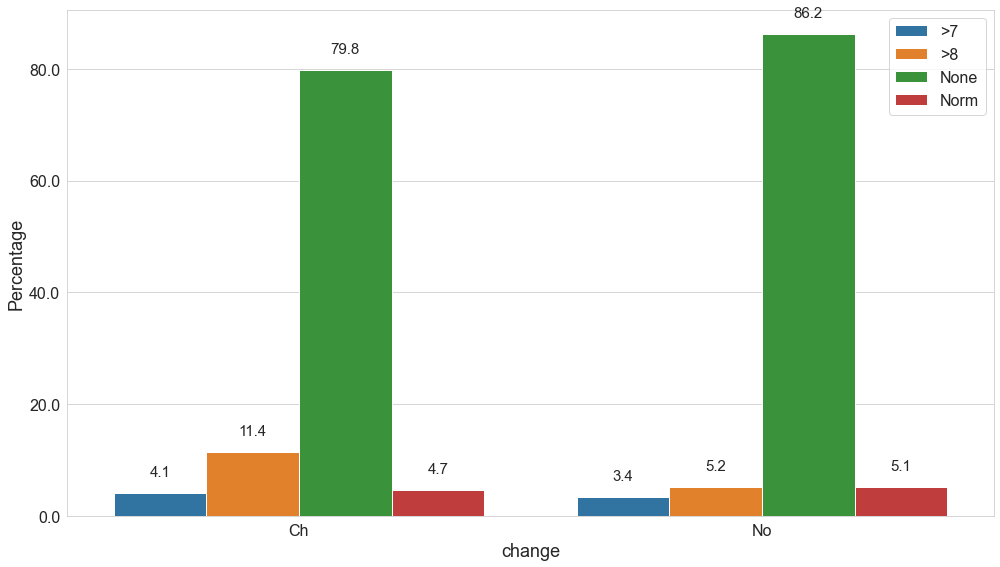

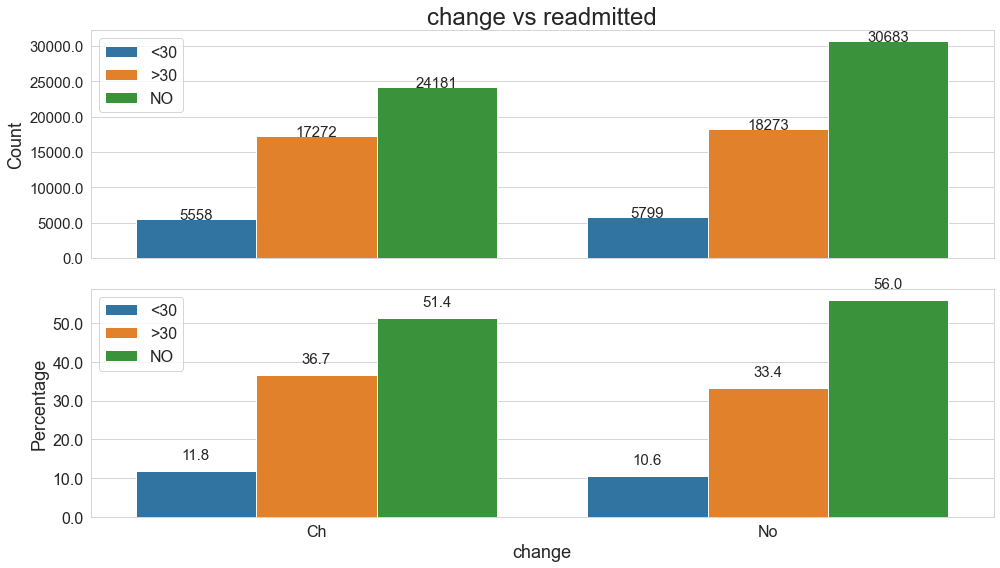

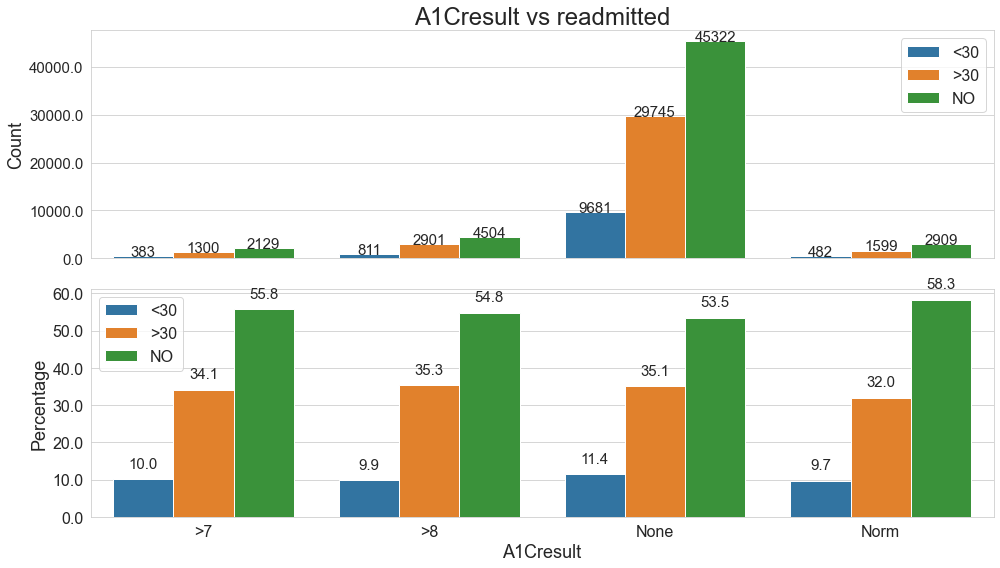

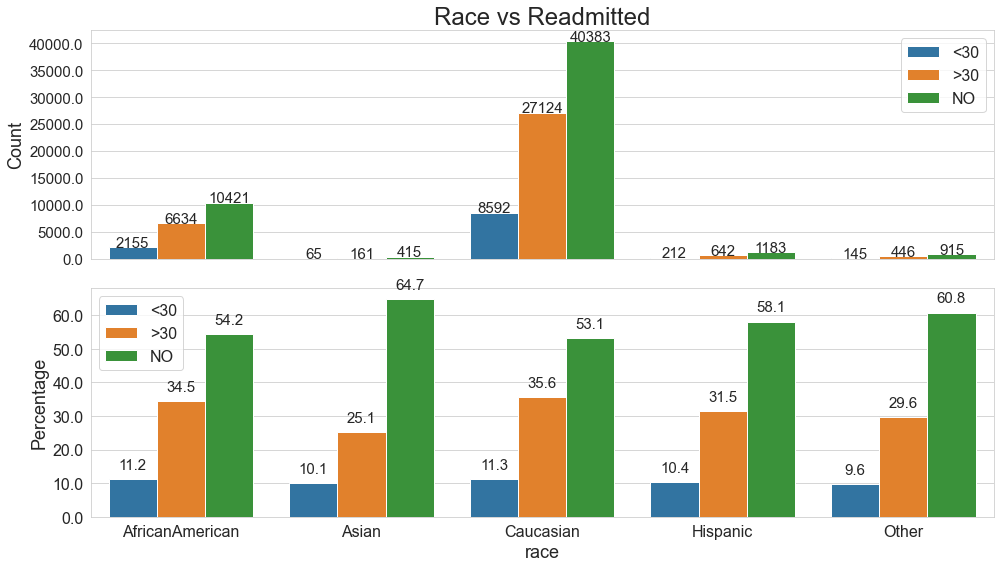

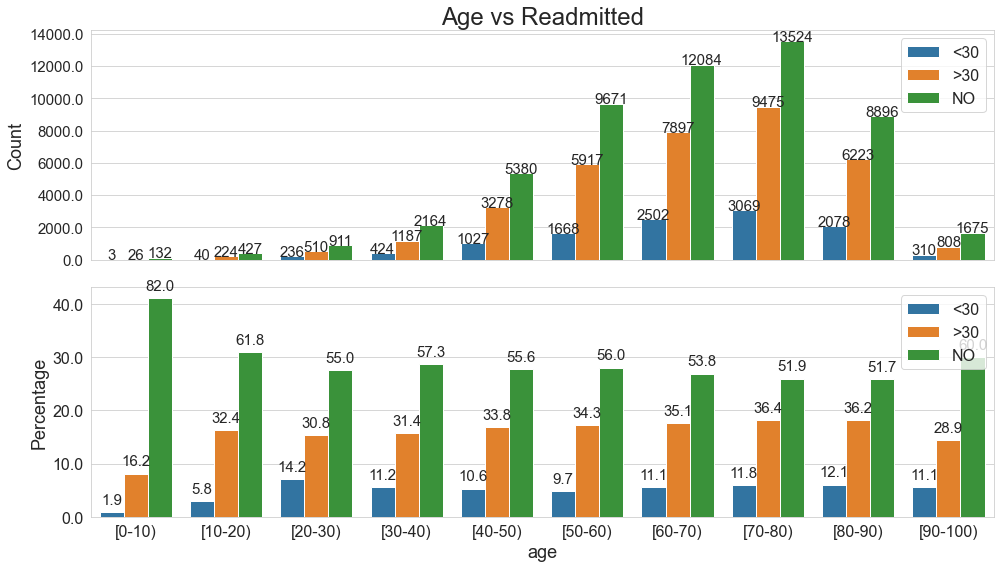

In [18]:
bar_plot_count_percentage(df, 'change', 'A1Cresult', 'change vs A1Cresult', plotType='Per')
bar_plot_count_percentage(df, 'change', 'readmitted', 'change vs readmitted', plotType='Both')
bar_plot_count_percentage(df, 'A1Cresult', 'readmitted', 'A1Cresult vs readmitted', plotType='Both')
bar_plot_count_percentage(df, 'race', 'readmitted', 'Race vs Readmitted', plotType='Both')
bar_plot_count_percentage(df, 'age', 'readmitted', 'Age vs Readmitted', 'Both')


In [19]:
def nan_heatmap(data):
    """ Creates a bar plot that compares 2 attributes, eg a random att vs
    the target attribute

    Parameters
    ----------
    df: (dataframe)

    Output:
    """
    fig, axes = plt.subplots(figsize=(10, 8))
    clmns = data.columns.tolist()
    if len(clmns) > 10:
        clmns1 = clmns[0:round(len(clmns)/2)]
        nht1 = sns.heatmap(data[clmns1].isnull(), cmap="viridis", yticklabels=False, cbar=False)
        plt.show()
        nht1.set_xticklabels(nht1.get_xmajorticklabels(), fontsize=18)
        figure = nht1.get_figure()

        fig, axes = plt.subplots(figsize=(10, 8))
        clmns2 = clmns[round(len(clmns)/2):-1]
        nht2 = sns.heatmap(data[clmns2].isnull(), cmap="viridis", yticklabels=False, cbar=False)
        plt.show()
        nht2.set_xticklabels(nht2.get_xmajorticklabels(), fontsize=18)
        figure = nht2.get_figure()
    else:
        nht = sns.heatmap(data[clmns].isnull(), cmap="viridis", yticklabels=False, cbar=False, )
        plt.show()
        nht.set_xticklabels(nht.get_xmajorticklabels(), fontsize=18)
        figure = nht.get_figure()


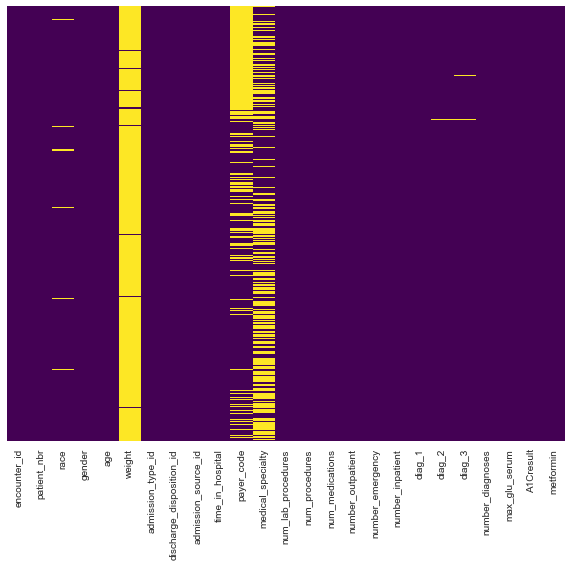

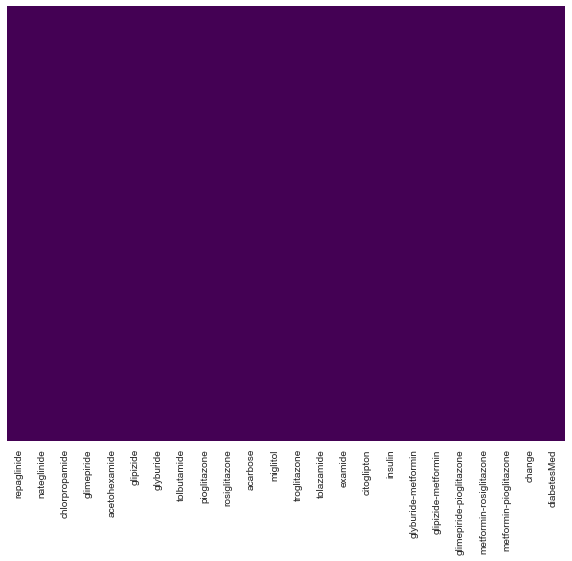

In [20]:
nan_heatmap(df)

In [21]:
  def replace_columnValues_dict(df, columnName, replace_dict):
        def is_number(s):
            try:
                float(s)
                return True
            except ValueError:
                return False
        columnsValues = list(df[columnName].values)
        for i, columnsValue in enumerate(columnsValues):
            for key, tuple_range in replace_dict.items():
                if is_number(columnsValues[i]):
                    if ('str' not in str(type(float(columnsValues[i])))):
                        if (int(float(columnsValues[i])) >= tuple_range[0]) and (int(float(columnsValues[i])) <= tuple_range[1]):
                            columnsValues[i] = key

        return columnsValues

In [22]:
# Droping rows that have nan for the following columns
df = df[~df['race'].isnull()]
df = df[~df['diag_1'].isnull()]
df = df[~df['diag_2'].isnull()]
df = df[~df['diag_3'].isnull()]

# Droping duplicates from the following column
df = df.drop_duplicates(subset=['patient_nbr'])

# Droping rows that have the following values for the X columns
df = df.loc[~df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21, 25, 26])]

In [23]:
replace_dict = {'Infectious': (1, 139),
                'Neoplasmic': (140, 239),
                'Hormonal': (240, 279),
                'Blood': (280, 289),
                'Mental': (290, 319),
                'Nervous': (320, 359),
                'Sensory': (360, 389),
                'Circulatory': (390, 459),
                'Respiratory': (460, 519),
                'Digestive': (520, 579),
                'Genitourinary': (580, 629),
                'Childbirth': (630, 679),
                'Dermatological': (680, 709),
                'Musculoskeletal': (710, 739),
                'Congenital': (740, 759),
                'Perinatal': (760, 779),
                'Miscellaneous': (780, 799),
                'Injury': (800, 999)}


for diag in ['diag_1', 'diag_2', 'diag_3']:
    df.loc[df[diag].str.startswith('250'), diag] = "Diabetes"
    df.loc[df[diag].str.startswith('V' or 'E'), diag] = "Accidental"
    df[diag] = replace_columnValues_dict(df, diag, replace_dict)

for diag in ['diag_1', 'diag_2', 'diag_3', 'medical_specialty']:
    top_x = df.groupby(diag).size().sort_values(ascending=False).keys().to_list()[:5]
    df.loc[~df[diag].isin(top_x), diag] = 'Other'


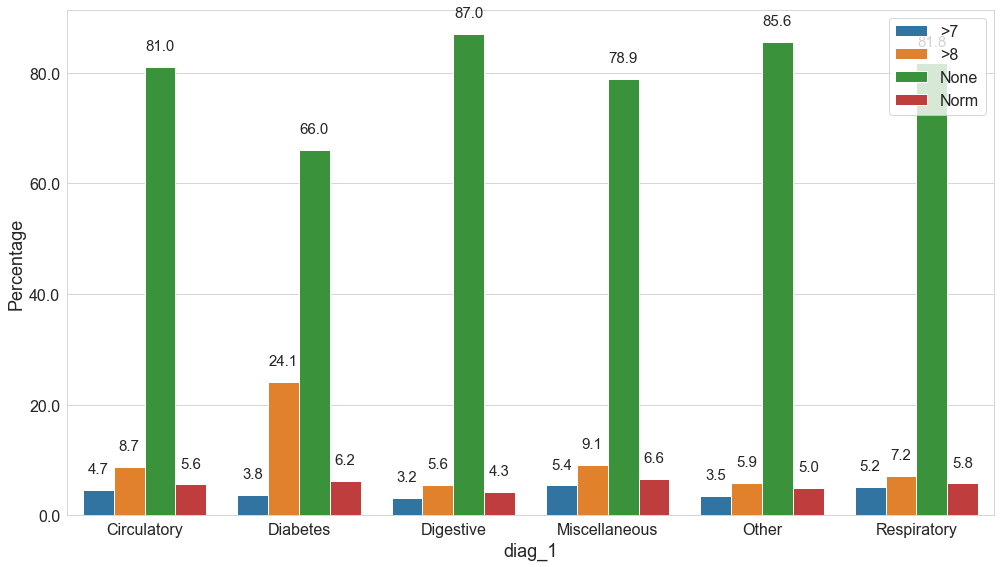

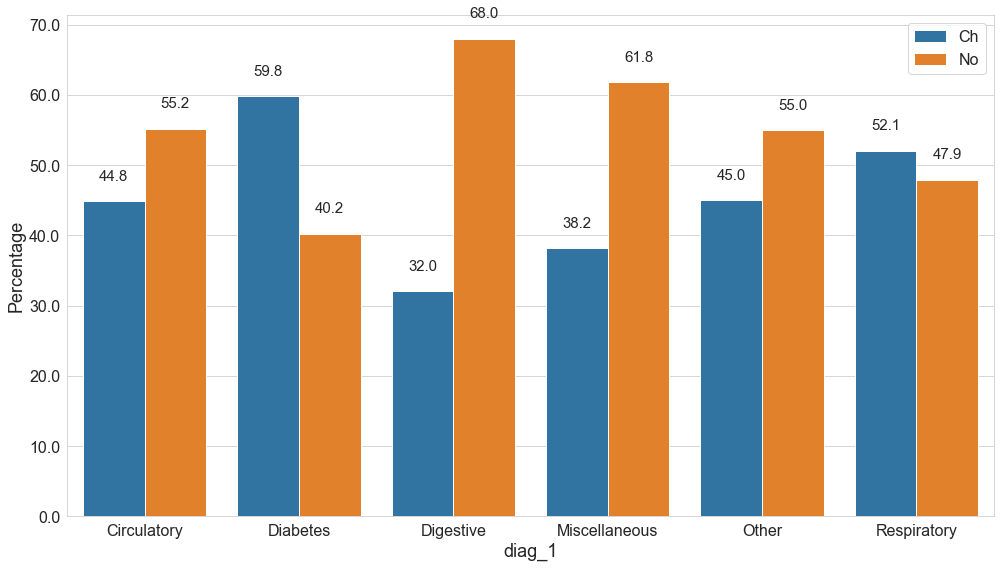

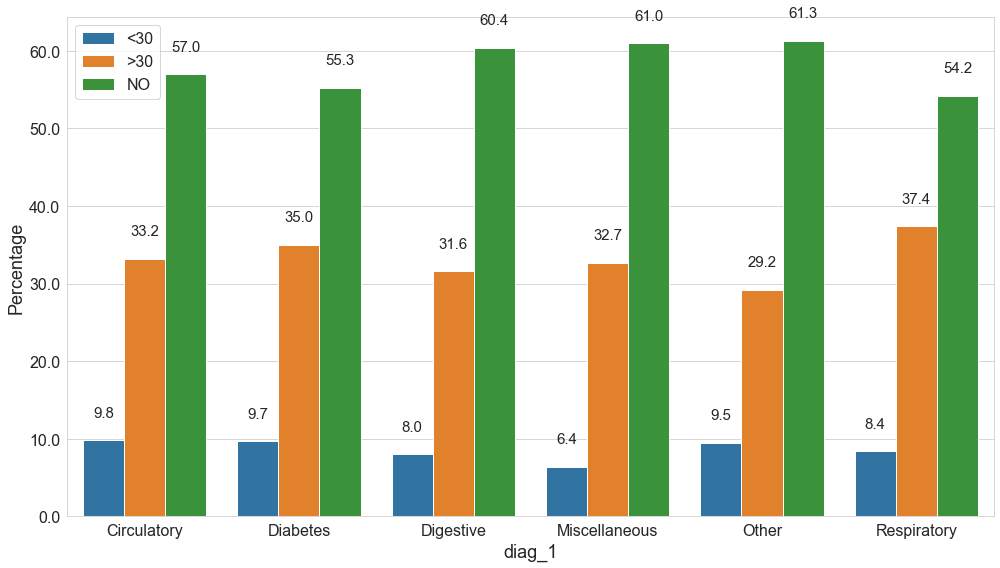

In [24]:
bar_plot_count_percentage(df, 'diag_1', 'A1Cresult', 'diag_1 vs A1Cresult', plotType='Per')
bar_plot_count_percentage(df, 'diag_1', 'change', 'diag_1 vs change', plotType='Per')
bar_plot_count_percentage(df, 'diag_1', 'readmitted', 'diag_1 vs readmitted', plotType='Per')

In [25]:
df = df.drop(['encounter_id', 'patient_nbr', 'payer_code', 'weight'], axis=1)

df['admission_type_id'] = pd.Series(['Emergency' if val in [1, 2] else 'Not Emergency' for val in df['admission_type_id']], index=df.index)
df['admission_source_id'] = pd.Series([2 if val in [7] else 1 if val in [1] else 0 for val in df['admission_source_id']], index=df.index)
df['discharge_disposition_id'] = pd.Series([1 if val in [1] else 0 for val in df['discharge_disposition_id']], index=df.index)

medicines1 = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
              'pioglitazone', 'rosiglitazone', 'acarbose', 'glyburide-metformin']
df = df.drop(medicines1, axis=1)
medicines2 = ['glipizide-metformin', 'tolazamide', 'tolbutamide', 'glimepiride-pioglitazone', 'citoglipton', 'examide',
              'troglitazone', 'acetohexamide', 'miglitol', 'metformin-rosiglitazone', 'metformin-pioglitazone']

df = df.drop(medicines2, axis=1)


In [26]:
def remove_rare_occurences(df, frequeThreshold=30):
    for x in list(df.columns):
        for y in list(df[x].unique()):
            if (len(df[df[x] == y][x]) <= frequeThreshold):
                print('Attr: ', x, ', /value: ', y, '/size: ', len(df[df[x] == y][x]))
                df = df[df[x] != y]
    return df


In [27]:
df = remove_rare_occurences(df)


Attr:  gender , /value:  Unknown/Invalid /size:  1
Attr:  num_lab_procedures , /value:  96 /size:  19
Attr:  num_lab_procedures , /value:  105 /size:  3
Attr:  num_lab_procedures , /value:  103 /size:  5
Attr:  num_lab_procedures , /value:  98 /size:  18
Attr:  num_lab_procedures , /value:  97 /size:  20
Attr:  num_lab_procedures , /value:  101 /size:  7
Attr:  num_lab_procedures , /value:  102 /size:  4
Attr:  num_lab_procedures , /value:  99 /size:  5
Attr:  num_lab_procedures , /value:  100 /size:  11
Attr:  num_lab_procedures , /value:  114 /size:  1
Attr:  num_lab_procedures , /value:  111 /size:  2
Attr:  num_lab_procedures , /value:  107 /size:  1
Attr:  num_lab_procedures , /value:  108 /size:  4
Attr:  num_lab_procedures , /value:  106 /size:  4
Attr:  num_lab_procedures , /value:  104 /size:  2
Attr:  num_lab_procedures , /value:  109 /size:  2
Attr:  num_lab_procedures , /value:  120 /size:  1
Attr:  num_lab_procedures , /value:  113 /size:  2
Attr:  num_lab_procedures , /va

In [28]:
df['readmitted'] = df.readmitted.replace({'<30': 1, '>30': 0, 'NO': 0})
descriptive_analysis(df, 'readmitted')

df1 = df[df.readmitted == 1]
df0 = df[df.readmitted == 0]
df0 = df0.sample(n=len(df1), random_state=42)
df = pd.concat([df0, df1])
    
X = df.drop(['readmitted'], 1)
y = df['readmitted']

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count              65785.000000         65785.000000      65785.000000   
mean                   0.636847             1.390332          4.278696   
std                    0.480912             0.733456          2.924608   
min                    0.000000             0.000000          1.000000   
25%                    0.000000             1.000000          2.000000   
50%                    1.000000             2.000000          4.000000   
75%                    1.000000             2.000000          6.000000   
max                    1.000000             2.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count        65785.000000    65785.000000     65785.000000       65785.000000   
mean            42.760173        1.427787        15.635874           0.259117   
std             19.794925        1.749790         7.920330           0.844385   
min      

In [29]:
from pandas.api.types import is_numeric_dtype
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # , KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


def data_transformation(X, numerical_features=[], categorical_features=[], cat_type=0):

    def get_column_names_from_ColumnTransformer(column_transformer, numerical_features):
        col_name = []
        for transformer_in_columns in column_transformer.transformers_[:]:  # the last transformer is ColumnTransformer's 'remainder'
            raw_col_name = transformer_in_columns[2]
            if transformer_in_columns[0] == 'numerical':
                raw_col_name = numerical_features
            if isinstance(transformer_in_columns[1], Pipeline):
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names()
            except AttributeError:  # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
            if isinstance(names, np.ndarray):  # eg.
                col_name += names.tolist()
            elif isinstance(names, list):
                col_name += names
            elif isinstance(names, str):
                col_name.append(names)
        return col_name

    # Numerical attributes are detected if not defined
    if numerical_features == []:
        numerical_features = [cols for cols in X.columns if is_numeric_dtype(X[cols])]
    num_features_index = [X.columns.get_loc(c) for c in numerical_features if c in X]
    if categorical_features == []:
        categorical_features = [cols for cols in X.columns if cols not in numerical_features]
    cat_features_index = [X.columns.get_loc(c) for c in categorical_features if c in X]

    # =====================================================================
    # Applying SimpleImputer and will search for different scalers using GridSearchCV
    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', MinMaxScaler())])

    if cat_type == 0:
        # Applying SimpleImputer and then OneHotEncoder
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    else:
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                                  ('onehot', OrdinalEncoder())])

    data_transformer = ColumnTransformer(transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)])

    # =====================================================================
    trasnformer = ('data_transformer', data_transformer)
    pipe_line = Pipeline([trasnformer])

    # =====================================================================

    X_fit = pipe_line.fit_transform(X)
    pipe_line.fit(X)
    col_names_pipeline = get_column_names_from_ColumnTransformer(data_transformer, numerical_features)

    df_fit = round(pd.DataFrame(X_fit, columns=col_names_pipeline), 3)
    return df_fit, pipe_line

In [30]:
X_tr, pipeline_tr = data_transformation(X, cat_type=0)
print(X_tr.columns)

X_tr, pipeline_tr = data_transformation(X, cat_type=1)
print(X_tr.columns)


Index(['discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'x0_AfricanAmerican', 'x0_Asian', 'x0_Caucasian',
       'x0_Hispanic', 'x0_Other', 'x1_Female', 'x1_Male', 'x2_[0-10)',
       'x2_[10-20)', 'x2_[20-30)', 'x2_[30-40)', 'x2_[40-50)', 'x2_[50-60)',
       'x2_[60-70)', 'x2_[70-80)', 'x2_[80-90)', 'x2_[90-100)', 'x3_Emergency',
       'x3_Not Emergency', 'x4_Cardiology', 'x4_Emergency/Trauma',
       'x4_Family/GeneralPractice', 'x4_InternalMedicine', 'x4_Other',
       'x4_Surgery-General', 'x5_Circulatory', 'x5_Diabetes', 'x5_Digestive',
       'x5_Miscellaneous', 'x5_Other', 'x5_Respiratory', 'x6_Circulatory',
       'x6_Diabetes', 'x6_Genitourinary', 'x6_Hormonal', 'x6_Other',
       'x6_Respiratory', 'x7_Circulatory', 'x7_Diabetes', 'x7_Genitourinary',
       'x7_Hormonal', 'x7_Other', 'x7_Respira

In [31]:
descriptive_analysis(X_tr)

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count              11958.000000         11958.000000      11958.000000   
mean                   0.570748             0.699490          0.268808   
std                    0.494990             0.364472          0.229170   
min                    0.000000             0.000000          0.000000   
25%                    0.000000             0.500000          0.077000   
50%                    1.000000             1.000000          0.231000   
75%                    1.000000             1.000000          0.385000   
max                    1.000000             1.000000          1.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count        11958.000000    11958.000000     11958.000000       11958.000000   
mean             0.452520        0.239676         0.273538           0.030371   
std              0.207448        0.292079         0.143211           0.095321   
min      

In [32]:
from EDA_ML_Functions.ML_functions import ML_models
ML = ML_models()

ModuleNotFoundError: No module named 'EDA_ML_Functions'

In [ ]:
results = ML.ML_Basic_Models(X_tr, y)

In [ ]:
print(results)